In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.impute._iterative import IterativeImputer #for numeric values
from sklearn.impute import SimpleImputer #for categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt 
import seaborn as sns
import lightgbm as lgb 
from category_encoders.target_encoder import TargetEncoder
import utils
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)


In [2]:
data = pd.read_csv('./data/Leads.csv')
label = 'Converted'

data.head(5)


,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
#a bit of EDA 
#selecting types of column to process them accordingly 
cat_columns = list(data.select_dtypes(include='object').columns)
num_columns = list(set(data.columns) - set(cat_columns)) 
num_columns.remove(label) #our label should not get in here

#examine nulls
print(data.shape, '\n', data.isnull().sum())


(9240, 34) 
 Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper      

In [4]:
#separate data
y = data[label]
X = data.drop([label], axis = 1)


In [5]:
#apply cleaning and encoding in EACH phase of the CV process 
splitter = StratifiedKFold()

f1_scores = [] #store results
auc_scores = []

for train_index, test_index in splitter.split(X = X, y = y):
    
    estim = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05)

    X_train_k, X_test_k = X.iloc[train_index], X.iloc[test_index]
    y_train_k, y_test_k = y.iloc[train_index], y.iloc[test_index]

    #creation of the pipeline each time
    X_train_k, X_test_k = utils.transform_data_oh(X_train = X_train_k, 
                                X_test = X_test_k, 
                                cat_columns = cat_columns, 
                                num_columns = num_columns 
                                )
    
    estim.fit(X = X_train_k, y = y_train_k)
    #get results
    preds = estim.predict(X=X_test_k)
    f1 = f1_score(y_true=y_test_k,y_pred=preds)
    auc = roc_auc_score(y_true=y_test_k,y_score=preds)
    
    f1_scores.append(f1)
    auc_scores.append(auc)

print('F1 average: ' + str(round(np.average(f1_scores), 3)))
print('AUC average: ' + str(round(np.average(auc_scores), 3)))


F1 average: 0.809
AUC average: 0.845


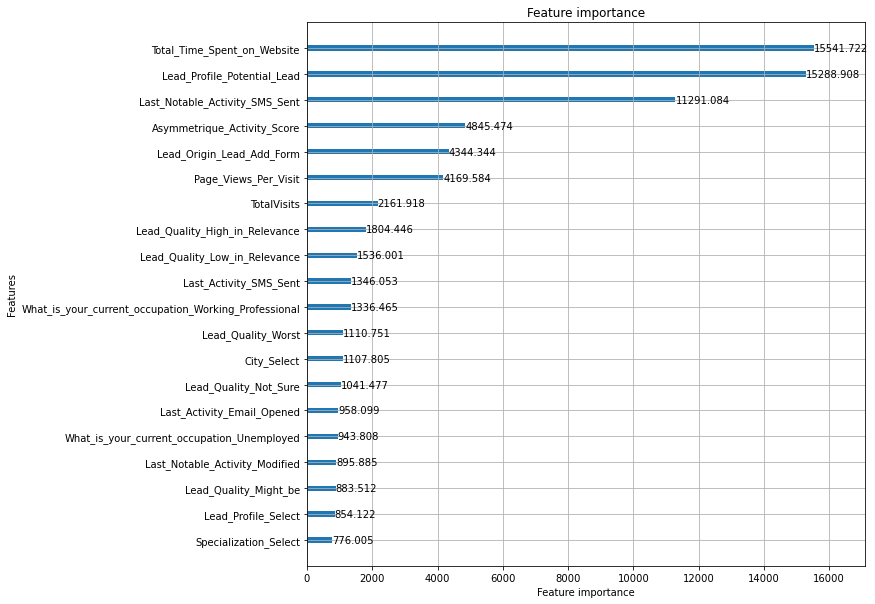

In [6]:
lgb.plot_importance(estim, max_num_features=20, figsize=(10,10), importance_type='gain')


In [7]:
import shap 
shap.initjs() 


In [8]:
#extract from the last iteration of K folds, just for demo purposes

explainer = shap.TreeExplainer(estim) 
shap_values = explainer.shap_values(X=X_train_k, y = y_train_k)


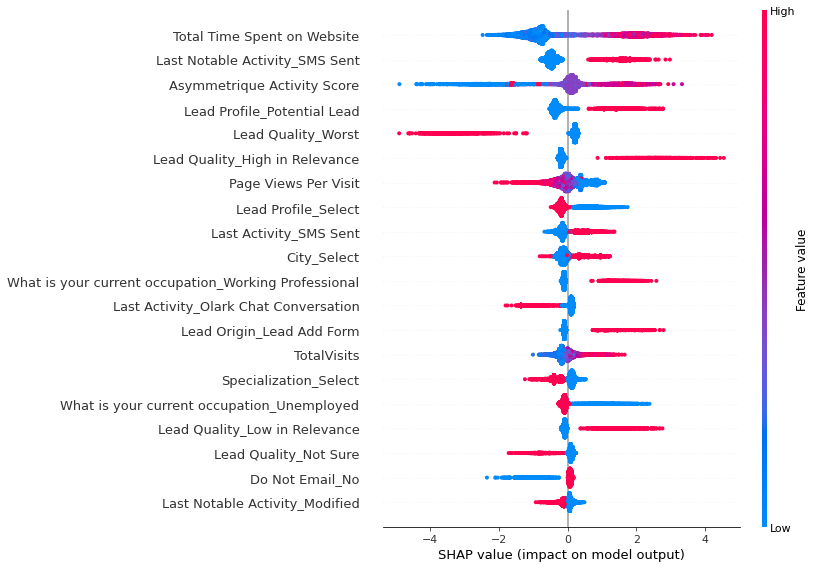

In [9]:
#explanation for cases that actually have been converted into sales
shap.summary_plot(shap_values=shap_values[1], features = X_train_k, feature_names = X_train_k.columns, 
                        plot_type = 'dot')
